### Laboratorium 6 - zadania

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

#### Zadanie 1 (1.5 pkt | 1.0 pkt)

Dany jest obraz `road`. Wykorzystaj transformatę Hougha do detekcji linii, aby wykryć pas jezdni. Wykorzystaj ulubiony detektor krawędzi i zaprezentuj wyniki pośrednie przed użyciem transformaty Hougha. Zapoznaj się z dokumentacją funkcji [`cv2.HoughLines`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a), zwłaszcza parametrami sterującymi rozdzielczością `rho`, `theta` oraz progiem `threshold` i przeanalizuj ich wpływ na osiągane wyniki.  
Nie skupiaj się na parametrach detektora krawędzi - znajdź odpowiednie i tych się trzymaj.  
Ostateczny rezultat zaprezentuj w postaci linii naniesionych na kopię obrazu wejściowego.

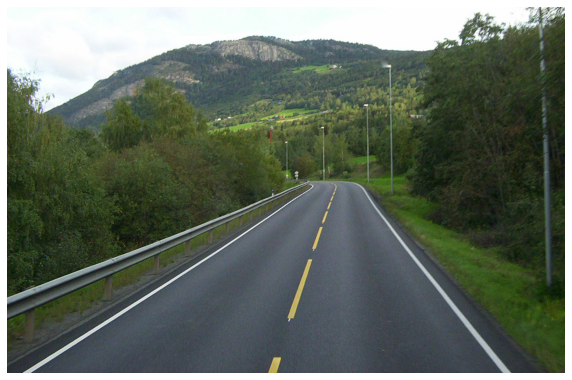

In [155]:
road = cv2.imread('Road_in_Norway.jpg')
road = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
plt.imshow(road);
plt.gcf().set_figwidth(10)
plt.gcf().set_figheight(10)
plt.axis('off');

In [114]:
def rhotheta2xy(line):
    # to samo co w przykładzie tylko w formie funkcji - na potrzeby rysowania
    # zwraca współrzędne odcinka leżącego na pojedynczej linii
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

def show_image(image, off=True):
    gray = len(image.shape) == 2 or image.shape[2] == 1
    plt.imshow(image, cmap='gray' if gray else None);
    plt.gcf().set_figwidth(10)
    plt.gcf().set_figheight(10)
    if off:
        plt.axis('off');

def show_image_grid(images, titles):
    w = len(images)
    h = len(images[0])
    fig, axes = plt.subplots(w, h, figsize=(w*10, h*10))
    
    if w == 1:
        axes = [axes]
    
    for row_image, row_title, row_ax in zip(images, titles, axes):
        for image, title, ax in zip(row_image, row_title, row_ax):
            gray = len(image.shape) == 2 or image.shape[2] == 1
            ax.imshow(image, cmap='gray' if gray else None)
            ax.set(title=title)
            ax.axis('off')
            
    return fig


def axshow(ax, image, title):
    gray = len(image.shape) == 2 or image.shape[2] == 1
    ax.imshow(image, cmap='gray' if gray else None)
    ax.set(title=title)
    ax.axis('off')
    

def general_formula(x1, y1, x2, y2):
    a = y1-y2
    b = x2-x1
    c = (x1-x2)*y1 + (y2-y1)*x1
    return a,b,c

Rozwiązanie:

In [17]:
from itertools import product


def param_generator(param_dict):
    for params in product(*param_dict.values()):
        yield {k: v for k, v in zip(param_dict.keys(), params)}


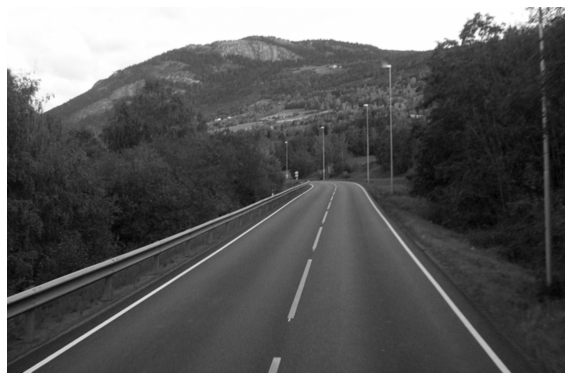

In [32]:
road_gray = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
road_gray = cv2.GaussianBlur(road_gray, (9, 9), 1)
show_image(road_gray)

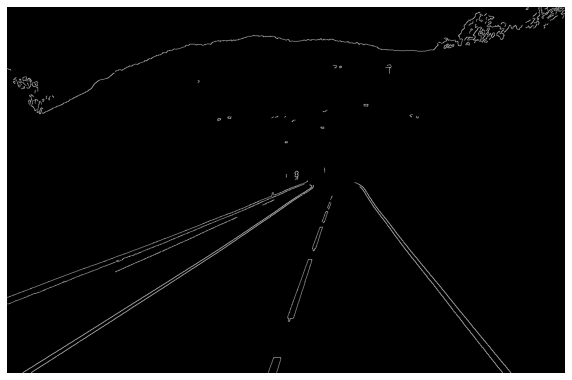

In [33]:
road_canny = cv2.Canny(image=road_gray, threshold1=200, threshold2=300)
show_image(road_canny)

(5698, 8480, -7825388)
(-7879, 6156, 3985304)
(9396, 3419, -8911945)


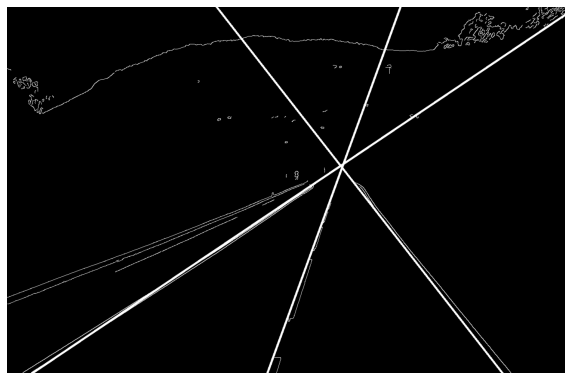

In [115]:
target = road_canny.copy()
x1,y1,x2,y2 = -3834, 3499, 4646, -2199
print(general_formula(x1,y1,x2,y2))
cv2.line(target, (x1,y1), (x2,y2), (255,0,0), 3)
x1,y1,x2,y2 = -2764, -4185, 3392, 3694
print(general_formula(x1,y1,x2,y2))
cv2.line(target, (x1,y1), (x2,y2), (255,0,0), 3)
x1,y1,x2,y2 = -872, 5003, 2547, -4393
print(general_formula(x1,y1,x2,y2))
cv2.line(target, (x1,y1), (x2,y2), (255,0,0), 3)
show_image(target)

In [203]:
target = np.array([
    (5698, 8480, -7825388),
    (-7879, 6156, 3985304),
    (9396, 3419, -8911945),
])

rhos = [0.4, 0.7, 1.0, 1.5, 2]
thetas = [90, 180, 270, 360]
thresholds = [20, 30, 50, 70, 100, 120, 160, 200, 300]

images_lst = []
titles_lst = []
scores_lst = []

for rho in rhos:
    for theta in thetas:
        for threshold in thresholds:
            lines = cv2.HoughLines(road_canny, rho, np.pi/theta, threshold)
            road_lines = road.copy()
            if lines is not None:
                loss = 0
                for line in lines:
                    x1,y1,x2,y2 = rhotheta2xy(line)
                    pred = np.array(general_formula(x1,y1,x2,y2))
                    loss += np.sum((target - pred) ** 2, axis=1).min()
                    cv2.line(road_lines, (x1,y1), (x2,y2), (255,0,0), 2)
                loss /= len(lines) * 1.1
                images_lst.append(road_lines)
                titles_lst.append(f"loss={loss:.0f}, rho={rho:.1f}, theta={theta:.4f}, threshold={threshold:.0f}")
                scores_lst.append(loss)

In [234]:
images = np.array(images_lst)
titles = np.array(titles_lst)
scores = np.array(scores_lst)

k = 30
keep = scores.argsort()[:k]
images = images[keep]
titles = titles[keep]
scores = scores[keep]

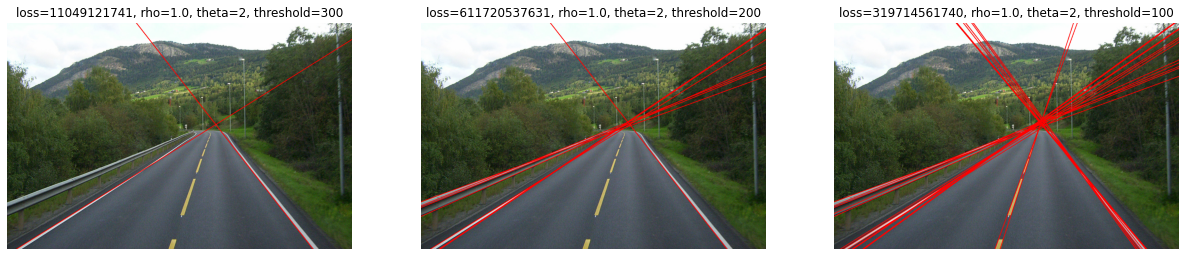

In [235]:
keep = [0, 19, 9]
images = images[keep]
titles = titles[keep]
scores = scores[keep]
wrap_col = 3
nrows = int(np.ceil(len(images) / wrap_col))
fig, axes = plt.subplots(nrows, wrap_col, figsize=(wrap_col*7, nrows*5))
 

for i, (image, title) in enumerate(zip(images, titles)):
    if nrows == 1:
        ax = axes[i]
    else:
        ax = axes[i // wrap_col, i % wrap_col]
    axshow(ax, image, title)

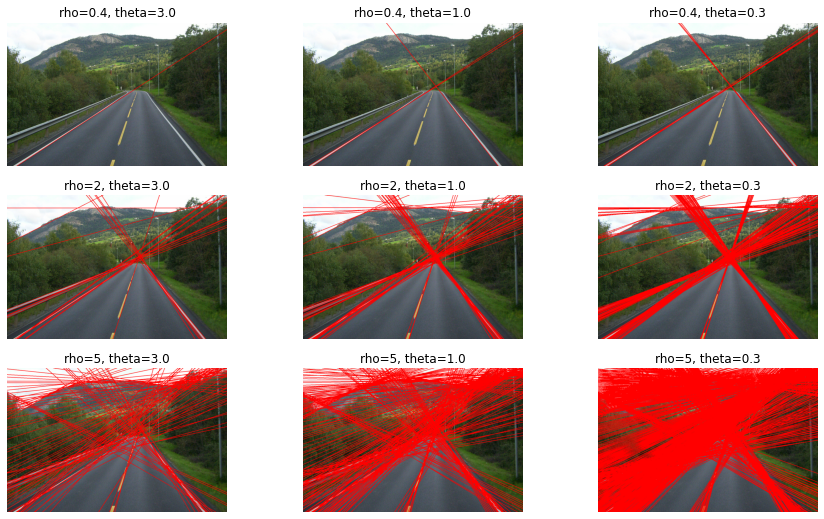

In [210]:
# rhos = [0.1, 0.4, 0.7, 1.0, 1.5, 2, 2.5, 3, 5, 10]
# thetas = [15, 30, 60, 90, 180, 270, 360, 400, 500, 600]
rhos = [0.4, 2, 5]
thetas = [60, 180, 600]

fig, axes = plt.subplots(len(rhos), len(thetas), figsize=(len(thetas)*5, len(rhos)*3))
 

for rho, row_axes in zip(rhos, axes):
    for theta, ax in zip(thetas, row_axes):
        lines = cv2.HoughLines(road_canny, rho, np.pi/theta, 140)
        road_lines = road.copy()
        if lines is not None:
            for line in lines:
                x1,y1,x2,y2 = rhotheta2xy(line)
#                 print(x1,y1,x2,y2)
                cv2.line(road_lines, (x1,y1), (x2,y2), (255,0,0), 2)
#             print()

        axshow(ax, road_lines, f"rho={rho}, theta={180/theta}")

#### Zadanie 2 (1.5 pkt | 1.0 pkt)

Dany jest obraz `coins`. Celem jest (1) przebadanie wpływu parametrów funkcji [`cv2.HoughCircles`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d) na znajdowane okręgi oraz (2) wykorzystanie transformaty Hougha do zliczenia monet znajdujących się na obrazie. Jak poprzednio, zacznij od uzyskania dobrej jakości detekcji krawędzi - natychmiast zauważysz, że im więcej na obrazie zakłóceń (tj. krawędzi nie będących interesującymi nas okręgami), tym gorsze będą rezultaty transformacji Hougha.  
Aby wyznaczyć sensowne wartości początkowe parametrów `HoughCircles`, przyjrzyj się geometrii obrazu - "na oko" przyjmij wartości `minDist`, `minRadius` i `maxRadius`; wybierz metodę `cv2.HOUGH_GRADIENT`, załóż $dp=1.5$ i przy tych wartościach znajdź wartość `param2`. Jeśli twój detektor krawędzi działa dobrze, parametr `param1` możesz wtedy pominąć.

Zwróć uwagę, że `cv2.HoughCircles` zwraca wynik w postaci zmiennoprzecinkowej `np.ndarray` o 3 wymiarach: (1, N, 3) gdzie N to liczba wykrytych okręgów a trójka liczb w ostatnim wymiarze odpowiada parametrom *x, y, r* wykrytego okręgu.

Zaprezentuj ostateczny wynik tak jak w zadaniu 1; do narysowania okręgów wykorzystaj funkcję [`cv2.circle`](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670) (pamiętaj, że oczekuje parametrów okręgu jako liczby całkowite!).

---

*Jeśli starczy czasu*: wykorzystując wykryte okręgi do dalszego przetwarzania obrazu, odróżnij monety srebrne od brązowych (policz jedne i drugie, zaznacz okręgami o różnych kolorach na obrazie).

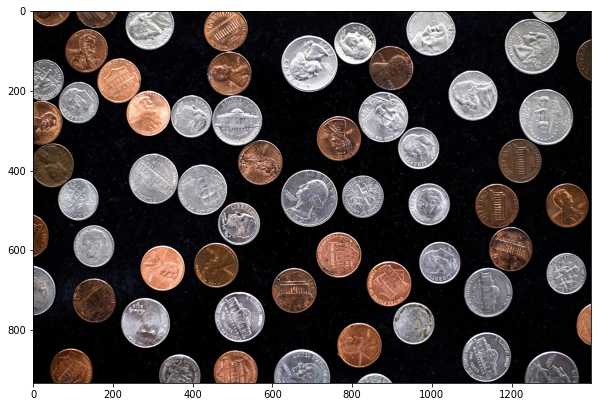

In [138]:
coins = cv2.imread('Coins.jpg')
coins = cv2.cvtColor(coins, cv2.COLOR_BGR2RGB)
plt.imshow(coins);
plt.gcf().set_figwidth(10)
plt.gcf().set_figheight(10)

Rozwiązanie:

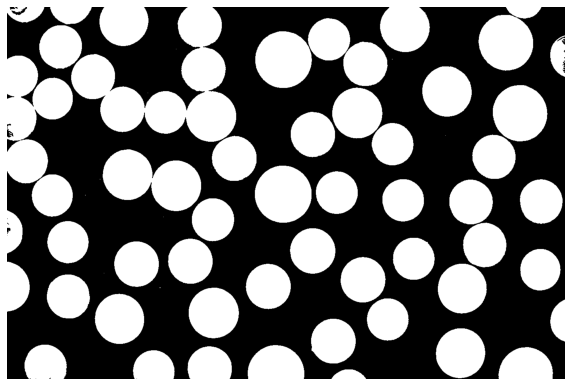

In [140]:
coins_gray = cv2.cvtColor(coins, cv2.COLOR_RGB2GRAY)

coins_gray = cv2.medianBlur(src=coins_gray, ksize=3)

thresh, coins_gray = cv2.threshold(coins_gray, thresh=40, maxval=255, type=cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(coins_gray, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
output = np.zeros_like(coins_gray)
coins_gray = cv2.drawContours(output, contours=contours, contourIdx=-1, color=1, thickness=-1)

show_image(coins_gray)

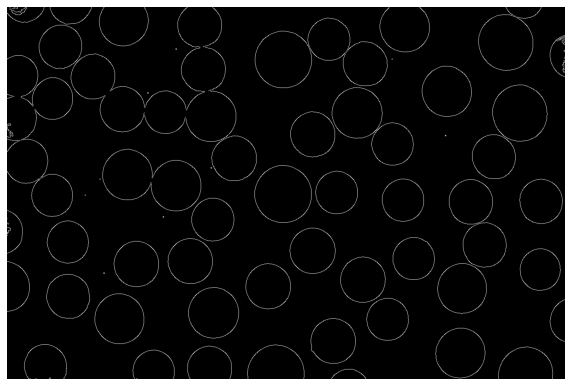

In [141]:
coins_edges = cv2.Canny(image=coins_gray, threshold1=1, threshold2=1)
show_image(coins_edges)

Number of yellow: 26
Number of gray: 32
Total: 58


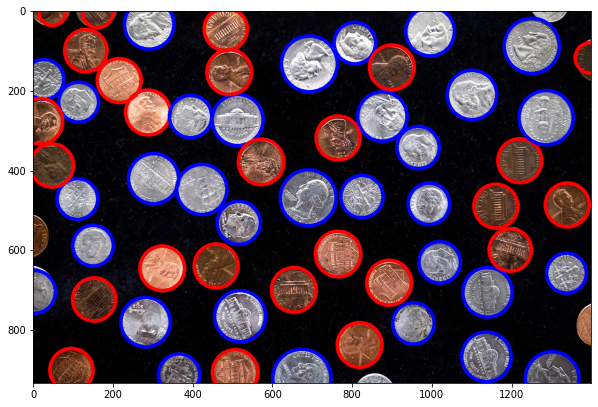

In [244]:
image_circles = coins.copy().astype(np.uint8)
circles = cv2.HoughCircles(image=coins_edges, method=cv2.HOUGH_GRADIENT, dp=1.5, minDist=40, minRadius=20, maxRadius=80, param2=30)
if circles is not None:
    circles = np.squeeze(circles)

    superpixels = []
    for circle in circles:
        x, y, r = circle
        mask = cv2.circle(img=np.full_like(coins, 255), center=(int(x), int(y)), radius=int(r), color=(0, 0, 0), thickness=-1)
        image_masked = cv2.subtract(image_circles, mask)
        image_masked = cv2.cvtColor(image_masked, cv2.COLOR_RGB2LAB).astype(np.float32)
        image_masked[image_masked == 0] = np.nan
        superpixels.append(np.nanmean(image_masked[..., 1:], axis=((0, 1))))
        
    superpixels = np.array(superpixels).astype(np.float32)
    c, labels, centers = cv2.kmeans(
        data=superpixels,
        K=2,
        bestLabels=None,
        criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),
        attempts=5, 
        flags=cv2.KMEANS_RANDOM_CENTERS,
    )
    std = np.std(centers, axis=1)
    arg = np.argsort(std)
    
    print('Number of yellow:', np.sum(labels == arg[1]))
    print('Number of gray:', np.sum(labels == arg[0]))
    print('Total:', len(labels))
    
    colors = [(255, 0, 0) if x == arg[1] else (0, 0, 255) for x in labels]
        
        
    for circle, color in zip(circles, colors):
        x, y, r = circle
        cv2.circle(img=image_circles, center=(int(x), int(y)), radius=int(r), color=color, thickness=8)

show_image(image_circles, off=False)